#### Set-up

In [1]:
import numpy as np
import json
import os
from post_processing import optimize_index, post_process_mask, refine_overlapping_masks, filter_largest_connected_component
from vis_labeling import read_cropped_image, calculate_bounding_box
from vis_labeling import plot_whale_mask, visualize_all_masks, visualize_baseline_bboxes_individually, visualize_baseline_bboxes, visualize_ann_bboxes

In [2]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

# https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
# https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
sam_checkpoint = "/data1/zhengyj/segment-anything/checkpoints/sam_vit_l_0b3195.pth"   # sam_vit_h_4b8939.pth
model_type = "vit_l"
sam_checkpoint = "/data1/zhengyj/segment-anything/checkpoints/sam_vit_h_4b8939.pth"   # sam_vit_h_4b8939.pth
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda:0")
predictor = SamPredictor(sam)

/data1/zhengyj/segment-anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


#### Create masks

20170807_2000441_2_5.jpg


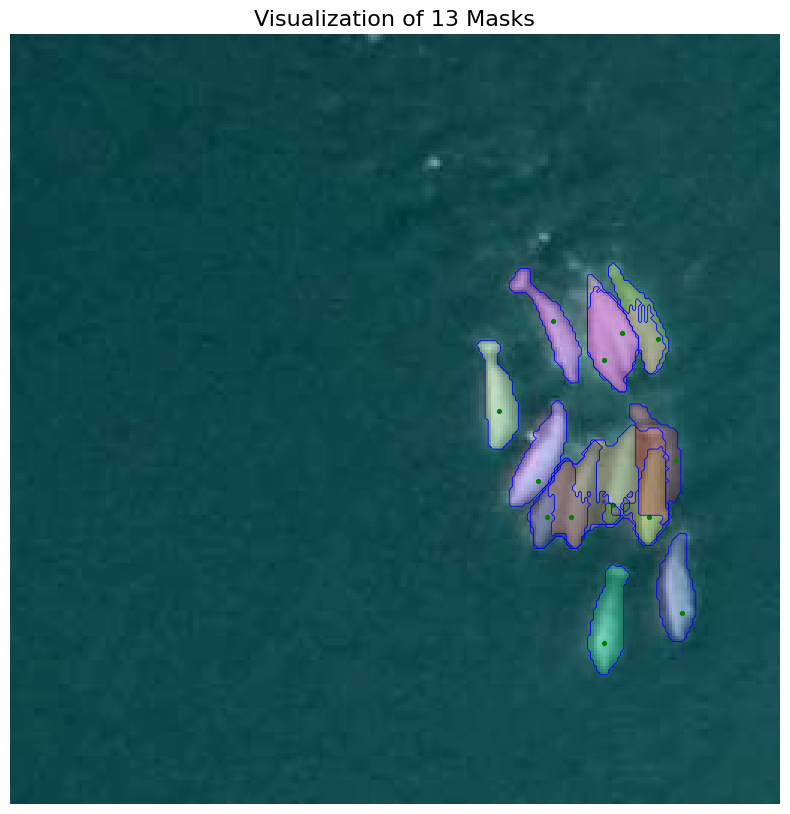

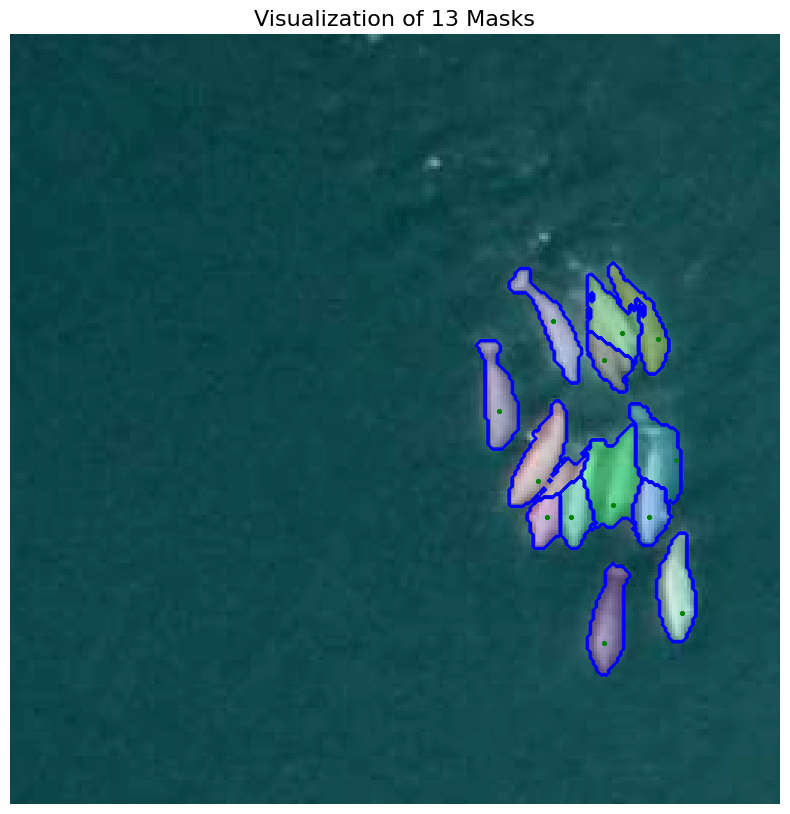

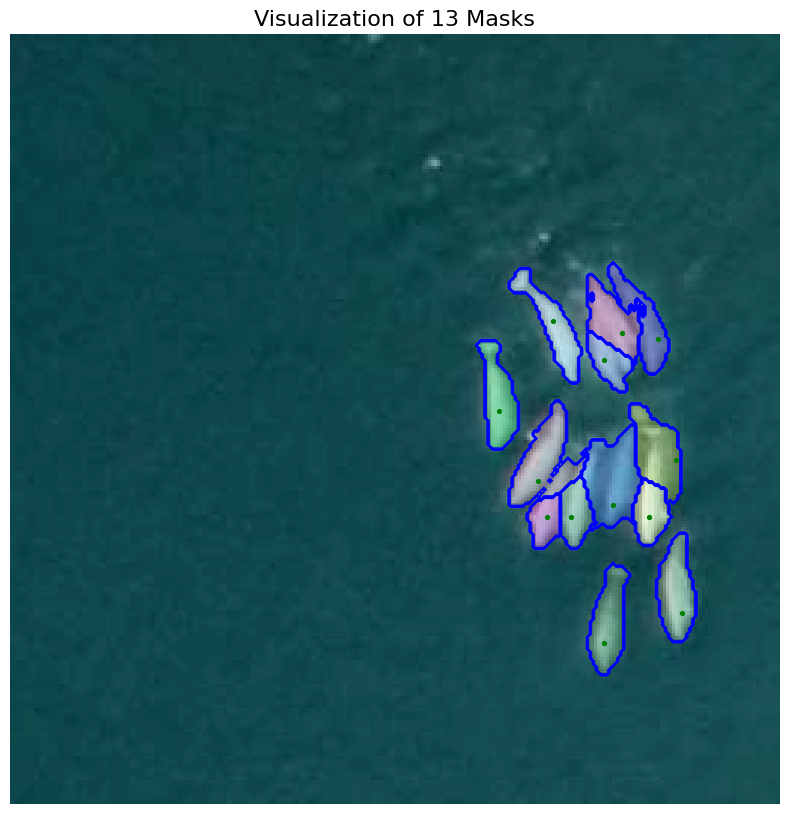

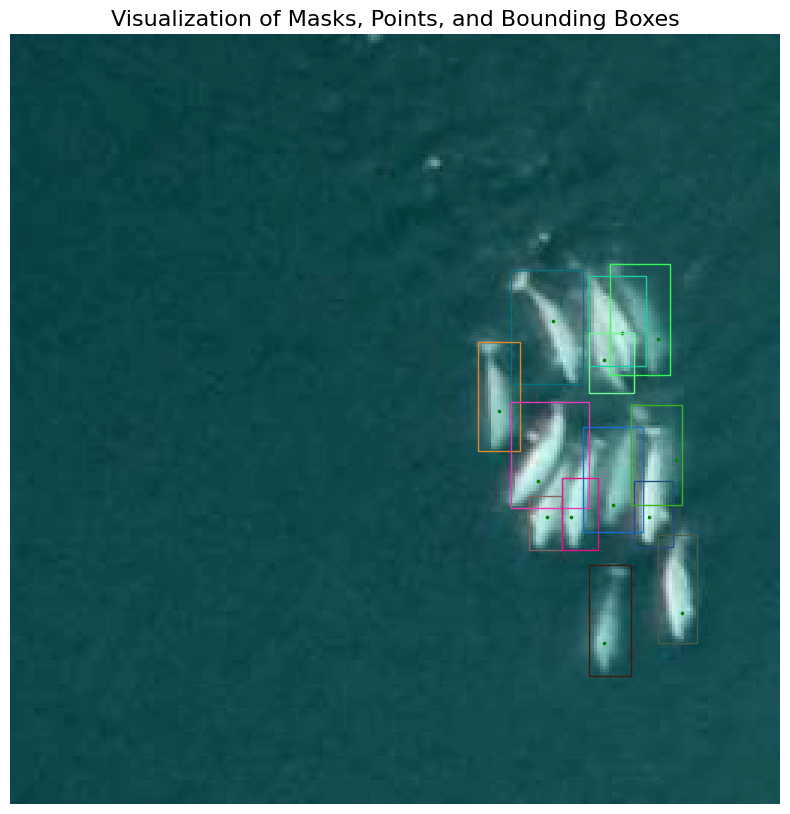

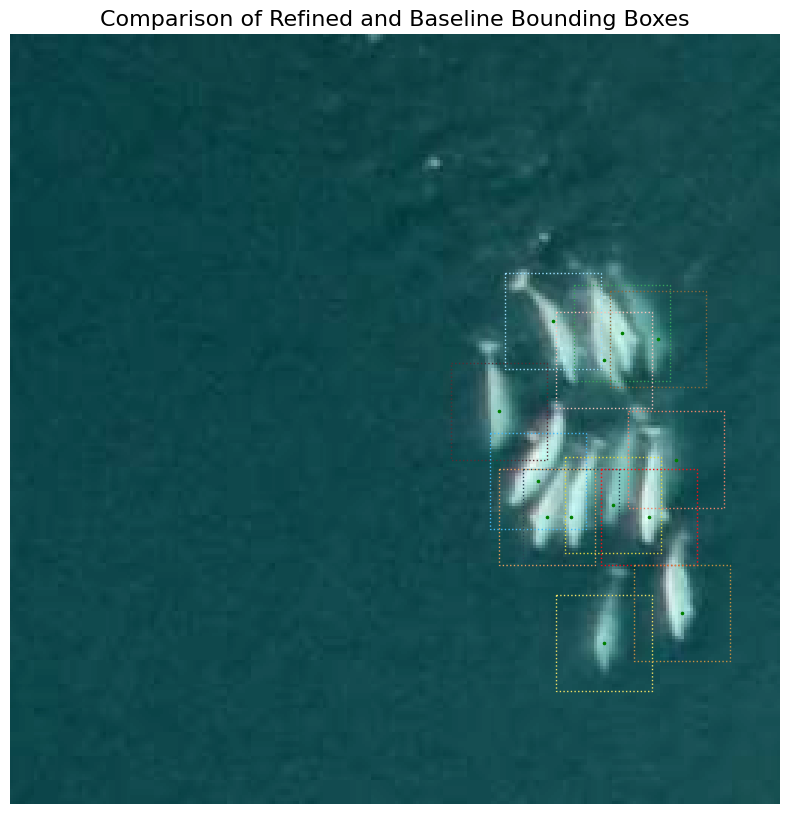

In [3]:
cropped_images_dir = 'aerial_256'

json_metadata_path = os.path.join(cropped_images_dir, 'metadata.json')
with open(json_metadata_path, 'r') as json_file:
    metadata = json.load(json_file)
crop_size = metadata['tiles'][0]['cropSize'][0] # 256 or 413
buffer_size = 16    # 32*0.13 = 4.2m

image_list = []
# Get filenames
for filename in os.listdir(cropped_images_dir):
    if filename.endswith('.jpg'):
        image_list.append(filename)

img_name = image_list[2]
print(img_name)

cropped_image_path = os.path.join(cropped_images_dir, img_name)
image = read_cropped_image(cropped_image_path, img_name)

# Get window info
found = False
for tile in metadata['tiles']:
    for window in tile['windows']:
        if window['dataURL'] == img_name:
            found = True
            break
    if found:
        break

# Swap [x, y] order for all labels before processing
for label in window['labels']:
    label['pointIndex'] = label['pointIndex'][::-1]

# Initialize masks storage
all_masks = []
all_points = []

# Read the labels and prepare input points and labels
for i, label in enumerate(window['labels']):
    if label['class'] != 'beluga':
        continue  # Skip non-beluga targets
    input_points = [label['pointIndex']]
    input_points = [optimize_index(image, label['pointIndex'], window_size=5)]
    input_labels = [1]  # Set current point as foreground
    input_box = None
    # Create box prompt
    point_row, point_col = optimize_index(image, label['pointIndex'], window_size=5)
    input_box = [point_row - buffer_size, point_col - buffer_size, point_row + buffer_size, point_col + buffer_size]
    input_points, input_labels, input_box = np.array(input_points), np.array(input_labels), np.array(input_box)

    # Set image for predictor
    predictor.set_image(image)
    masks, scores, low_res_masks = predictor.predict(
        point_coords=input_points, point_labels=input_labels,
        box=input_box,
        multimask_output=False,
        return_logits=False
    )
    masks = post_process_mask(masks, input_box)
    all_masks.append(masks[0])  # Store the single mask
    all_points.append(label['pointIndex'])  # Store the point index

    bbox = calculate_bounding_box(masks[0])
    label['bbox'] = bbox
    if 0:
        plot_whale_mask(image, input_points, input_labels, input_box, masks, scores, figsize=(6,6), dpi=100)

visualize_all_masks(image, all_masks, all_points)
# for i, mask in enumerate(all_masks):
#     plot_whale_mask(image, np.array([all_points[i]]), np.array([1]), None, [mask], [1.0], figsize=(6, 6), dpi=100)
# Perform mask refinement to resolve overlaps
refined_masks = refine_overlapping_masks(all_masks, all_points)

visualize_all_masks(image, refined_masks, all_points)

# for i, mask in enumerate(refined_masks):
#     plot_whale_mask(image, np.array([all_points[i]]), np.array([1]), None, [mask], [1.0], figsize=(6, 6), dpi=100)
# Filter each refined mask to retain only the largest connected component
refined_masks = [filter_largest_connected_component(mask) for mask in refined_masks]
# for i, mask in enumerate(refined_masks):
#     plot_whale_mask(image, np.array([all_points[i]]), np.array([1]), None, [mask], [1.0], figsize=(6, 6), dpi=100)
visualize_all_masks(image, refined_masks, all_points)
visualize_ann_bboxes(image, refined_masks, all_points)
visualize_baseline_bboxes(image, refined_masks, all_points, buffer_size=buffer_size)
# visualize_baseline_bboxes_individually(image, refined_masks, all_points, buffer_size=buffer_size)

# for i, mask in enumerate(refined_masks):
#     plot_whale_mask(image, np.array([all_points[i]]), np.array([1]), None, [mask], [1.0], figsize=(6, 6), dpi=100)